## Topic: A Transfer Learning-Based Approach for Sarcasm Detection on Twitter: Case Study of the EndSARS

#### By: Damilola Falusi
#### Student No: 202206108

In [ ]:
import re

#### Reading the data

In [ ]:
input_df = pd.read_csv('EndSars_Tweets (1).csv')

In [ ]:
input_df.info()

In [ ]:
def drop_columns(input_df, tweet_col='Text'):
    """
    Drops all other columns except the specified tweet column.

    Parameters:
    - input_df: pandas DataFrame, the input DataFrame containing tweets data.
    - tweet_col: str, the name of the column containing tweets.

    Returns:
    - pandas DataFrame: a new DataFrame with only the specified tweet column.
    """
    # Drop columns other than the specified tweet column
    df = input_df[tweet_col].copy()

    return df

In [ ]:
tweet_df = drop_columns(input_df)

tweet_df.info()

In [ ]:
tweet_df.to_csv('df_tweet_single_col.csv')

In [ ]:
tweet_df_lst = tweet_df.to_list() # converting to list for faster operations

tweet_df_lst[:5] # preview the first five in the list

In [ ]:
def clean_tweets_list(tweets_list):
    """
    Cleans a list of tweets by removing URLs, special characters, and converting
    to lowercase.

    Parameters:
    - tweets_list: list of str, a list containing tweets.

    Returns:
    - list of str: a new list with cleaned tweets.
    """
    # Function to clean a single tweet
    def clean_tweet(tweet):
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Remove special characters and numbers
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
        # Convert to lowercase
        tweet = tweet.lower()
        return tweet

    # Apply the clean_tweet function to each tweet in the list
    cleaned_tweets = [clean_tweet(tweet) for tweet in tweets_list]

    return cleaned_tweets

In [ ]:
clean_tweets = clean_tweets_list(tweet_df_lst) # apply the clean_tweets_list function

In [ ]:
clean_tweets[:5] # preview the first five of the cleaned tweets

In [ ]:
df_clean_tweets = pd.DataFrame(clean_tweets, columns=['Cleaned_Tweets'])

#df_clean_tweets.head()

df_clean_tweets.to_csv('cleaned_tweet_data.csv')

In [ ]:
df_clean_tweets.info()

### Wordcloud Visualization

In [ ]:
def visualize_wordcloud(cleaned_tweets):
    """
    Visualizes a word cloud from a list of cleaned tweets.

    Parameters:
    - cleaned_tweets: list of str, a list containing cleaned tweets.
    """
    # Combine cleaned tweets into a single string
    combined_text = ' '.join(cleaned_tweets)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
visualize_wordcloud(clean_tweets)

# --------------------------- Removal of Non-English Words ----------------------------------

The tweet data consists of so many slangs and words that are not relevant to the current study, thus, I am removing them all from the tweets.
I am using the tweets data already cleaned from urls and special characters. In addition, the tweets with number of words less than 3 are dropped as most of them are just probably tagging and irrelevant.
After the operation, I save a new dataframe called "cleaned_data_without_short_tweets.csv"

In [1]:
# import the libraries
import pandas as pd
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [ ]:
# Load your data - data free of urls and special characters
df = pd.read_csv('cleaned_tweet_data.csv')

df.head()

In [13]:
# Drop rows with NaN values in the 'Tweet' column
# Removing non-English words may have create empty rows
df = df.dropna(subset=['Tweet'])

In [ ]:
# Instead of processing the entire dataset, let's take a smaller random sample for testing and development. 
# This helps to iterate more quickly. Otherwise, you run out of memory!
# Text data are generally heavy so I use 1% for evaluation
# When I used 50% of the data, for two todays, it was still running so I opted for 1%
df_sample = df.sample(frac=0.01)  # 1% random sample of the data

df_sample.head()

In [20]:
# Function to filter out non-English words
def filter_non_english(tweet):
    english_words = set(words.words())
    tokens = word_tokenize(tweet)
    filtered_tokens = [word.lower() for word in tokens if word.lower() in english_words]
    return ' '.join(filtered_tokens)

In [21]:
# Function to remove stop words
def remove_stopwords(tweet):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(tweet)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [ ]:
# Apply the filtering functions to the 'Tweet' column
df_sample['Tweet'] = df_sample['Tweet'].apply(filter_non_english)
df_sample['Tweet'] = df_sample['Tweet'].apply(remove_stopwords)

In [ ]:
# Drop rows with empty 'Tweet' column (if any)
df_sample = df_sample.dropna(subset=['Tweet'])

In [ ]:
# Drop rows with tweets containing fewer than or equal to three words
df_sample = df_sample[df_sample['Tweet'].apply(lambda x: len(x.split()) > 3)]

In [ ]:
# Save the new DataFrame to a new CSV file
df_sample.to_csv('cleaned_data_without_short_tweets.csv', index=False)

# ------------------------------------ Sarcasm Labeling -----------------------------------------
After the data is cleaned and now have just English words, I am using the polarity in the tweets to label each tweet.
- The assumption is that sarcastic tweets are negative ("1") and others are non-sarcastic ("0").
- The assumption that sarcastic tweets are labeled as negative ("1") while non-sarcastic tweets are labeled as positive ("0") in sentiment analysis is a simplification based on the common association of sarcasm with negative sentiment.
- Sarcasm often involves expressing the opposite of the intended meaning, which may lead to confusion or misinterpretation.
- In addition, for the current case-study of EndSARS, people are bound to be negative about the government and the associated agencies.
- It is not a perfect assumption, however, it seems to be reasonable considering the timeframe and the available resources. Further studies could leverage on this result and use other approaches for likely improved results. 

NOTE: I will later be using BERT model on the dataset obtained from this approach which is where the Transfer Learning part of the project will be applied. In other words, I am only using sentiment analysis for labeling of the tweets.

In [26]:
from textblob import TextBlob # Text classification library

In [28]:
def classify_sentiment(dataframe):
    # Function to classify sentiment using TextBlob
    def get_sentiment(tweet):
        analysis = TextBlob(tweet)
        # Classify polarity as positive (1) or negative (0)
        return 1 if analysis.sentiment.polarity < 0 else 0

    # Apply the sentiment analysis function to the "Tweet" column
    dataframe['Labels'] = dataframe['Tweet'].apply(get_sentiment)

    return dataframe

In [29]:
# Call the function to classify sentiment and add the 'Labels' column
df = classify_sentiment(df)

In [ ]:
df.drop(['Label'], axis=1, inplace=True)

In [ ]:
# Save the new DataFrame with the 'Labels' column
df.to_csv('classified_tweets.csv', index=False)

In [ ]:
df.head()

In [44]:
len(df[df['Labels']==1]) # Number of sarcastic tweets
len(df[df['Labels']==0]) # Number of non-sarcastic tweets

4947

# ---------------------------------- Modelling and Evaluation -----------------------------------

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [12]:
# Load the cleaned tweets dataframe
df = pd.read_csv('classified_tweetss.csv')
df.head()

,Tweet,Labels
0,mind running cant sleep keep thinking country ...,0
1,basically back square zero bastard didnt even ...,0
2,state government hour curfew,0
3,case didnt get summary broadcast dont give damn,0
4,holding today know forward thank kind understa...,0


In [14]:
cleaned_tweets = df['Tweet'].tolist()

### WordCloud - Only English Words

In [19]:
def visualize_wordcloud(cleaned_tweets):
    """
    Visualizes a word cloud from a list of cleaned tweets.

    Parameters:
    - cleaned_tweets: list of str, a list containing cleaned tweets.
    """
    # Combine cleaned tweets into a single string
    combined_text = ' '.join(cleaned_tweets)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

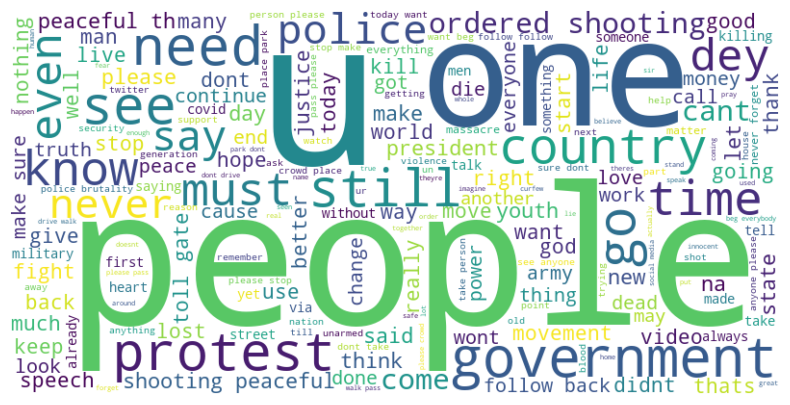

In [20]:
visualize_wordcloud(cleaned_tweets)

## Logistic Regression - Classification

In [22]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['Tweet'], df['Labels'], test_size=0.2, random_state=42
)

In [23]:
# Use TF-IDF Vectorizer for feature extraction
vectorizer = TfidfVectorizer(max_features=1000)
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

In [24]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_features, train_labels)

LogisticRegression(max_iter=1000)

In [25]:
# Make predictions on the test set
predictions = model.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)

In [26]:
# Display results for Logistic Regression
print("Logistic Regression Results:")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(test_labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))

Logistic Regression Results:
Accuracy: 0.8405003909304144
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.91       988
           1       0.92      0.33      0.48       291

    accuracy                           0.84      1279
   macro avg       0.88      0.66      0.69      1279
weighted avg       0.85      0.84      0.81      1279

Confusion Matrix:
 [[980   8]
 [196  95]]


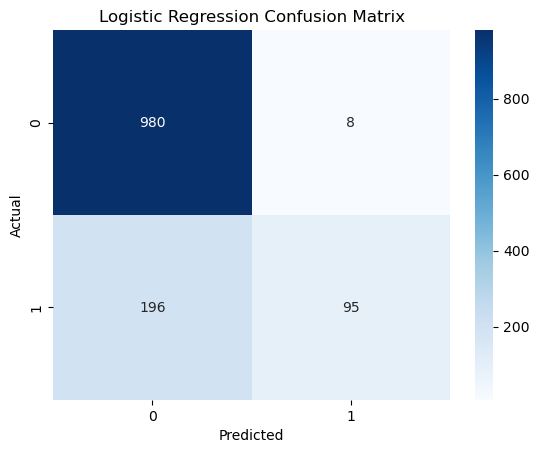

In [27]:
# Plot confusion matrix for Logistic Regression
sns.heatmap(confusion_matrix(test_labels, predictions), annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## RandomForest - Classification

In [4]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# RandomForest Model
# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_rf = vectorizer.fit_transform(train_df['Tweet'])
X_test_rf = vectorizer.transform(test_df['Tweet'])
y_train_rf = train_df['Labels']
y_test_rf = test_df['Labels']

In [6]:
# Train RandomForest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

In [7]:
# Make predictions and evaluate
rf_predictions = rf_classifier.predict(X_test_rf)
rf_accuracy = accuracy_score(y_test_rf, rf_predictions)

In [8]:
# Display results for RandomForest
print("RandomForest Results:")
print("Accuracy:", rf_accuracy)
print("Classification Report:\n", classification_report(y_test_rf, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, rf_predictions))

RandomForest Results:
Accuracy: 0.8819390148553558
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       988
           1       0.78      0.66      0.72       291

    accuracy                           0.88      1279
   macro avg       0.84      0.80      0.82      1279
weighted avg       0.88      0.88      0.88      1279

Confusion Matrix:
 [[935  53]
 [ 98 193]]


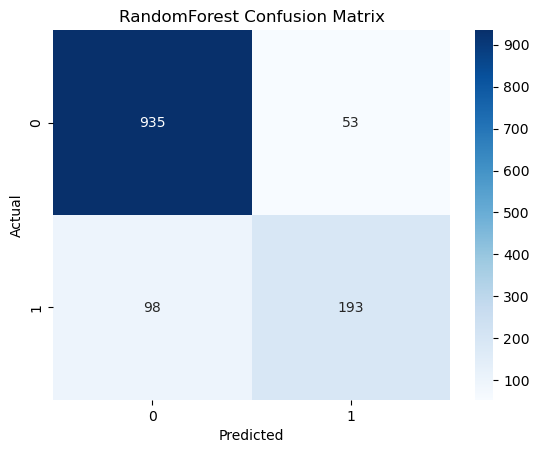

In [9]:
# Plot confusion matrix for RandomForest
sns.heatmap(confusion_matrix(y_test_rf, rf_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('RandomForest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine

In [28]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [29]:
# Support Vector Machine (SVM)
# Convert text data to numerical features using TF-IDF
vectorizer_svm = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_svm = vectorizer_svm.fit_transform(train_df['Tweet'])
X_test_svm = vectorizer_svm.transform(test_df['Tweet'])
y_train_svm = train_df['Labels']
y_test_svm = test_df['Labels']

In [30]:
# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_svm, y_train_svm)

SVC(kernel='linear', random_state=42)

In [31]:
# Make predictions and evaluate
svm_predictions = svm_classifier.predict(X_test_svm)
svm_accuracy = accuracy_score(y_test_svm, svm_predictions)

In [32]:
# Display results for SVM
print("SVM Results:")
print("Accuracy:", svm_accuracy)
print("Classification Report:\n", classification_report(y_test_svm, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test_svm, svm_predictions))

SVM Results:
Accuracy: 0.8850664581704457
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       988
           1       0.87      0.58      0.70       291

    accuracy                           0.89      1279
   macro avg       0.88      0.78      0.81      1279
weighted avg       0.88      0.89      0.88      1279

Confusion Matrix:
 [[962  26]
 [121 170]]


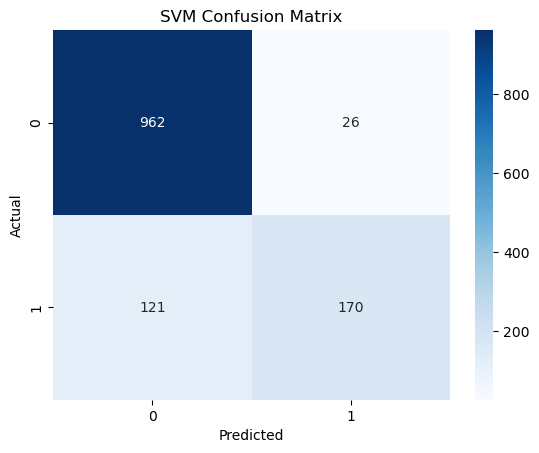

In [33]:
# Plot confusion matrix for SVM
sns.heatmap(confusion_matrix(y_test_svm, svm_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## BERT Model

In [10]:
# BERT Model
# Tokenize and prepare data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128  # Set max length of tokens

In [11]:
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    for sentence in tqdm(data['Tweet']):
        encoded_data = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(data['Labels'].values)

    return TensorDataset(input_ids, attention_masks, labels)

In [12]:
train_data = tokenize_data(train_df)
test_data = tokenize_data(test_df)

100%|█████████████████████████████████████████████████████████████████████████████| 1279/1279 [00:02<00:00, 479.84it/s]


In [13]:
# Train BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\pc\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [16]:
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate BERT model
model.eval()
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████| 1279/1279 [2:56:20<00:00,  8.27s/it]


In [17]:
bert_predictions = []
true_labels = []

for batch in tqdm(test_loader):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = F.softmax(logits, dim=1)
        bert_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

bert_accuracy = accuracy_score(true_labels, bert_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [14:25<00:00,  2.71s/it]


In [18]:
# Display results for BERT
print("\nBERT Results:")
print("Accuracy:", bert_accuracy)
print("Classification Report:\n", classification_report(true_labels, bert_predictions))
print("Confusion Matrix:\n", confusion_matrix(true_labels, bert_predictions))


BERT Results:
Accuracy: 0.7724784988272088
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87       988
           1       0.00      0.00      0.00       291

    accuracy                           0.77      1279
   macro avg       0.39      0.50      0.44      1279
weighted avg       0.60      0.77      0.67      1279

Confusion Matrix:
 [[988   0]
 [291   0]]


C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


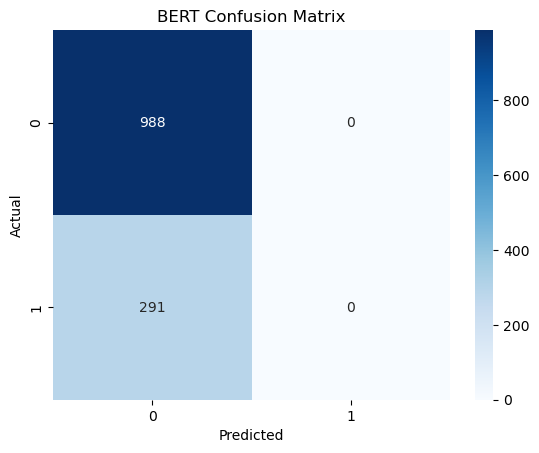

In [19]:
# Plot confusion matrix for BERT
sns.heatmap(confusion_matrix(true_labels, bert_predictions), annot=True, cmap='Blues', fmt='g')
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Word2Vec Application on the Tweet Data

In [29]:
# import the dataframe
df = pd.read_csv('classified_tweets.csv')
df.head()

,Tweet,Labels
0,mind running cant sleep keep thinking country ...,0
1,basically back square zero bastard didnt even ...,0
2,state government hour curfew,0
3,case didnt get summary broadcast dont give damn,0
4,holding today know forward thank kind understa...,0


In [20]:
# sarcastic and non-sarcastic statistics
print("Number of sarcastic tweets: ", len(df[df['Labels'] ==1]))
print("Number of non-sarcastic tweets: ", len(df[df['Labels'] ==0]))

Number of sarcastic tweets:  1447
Number of non-sarcastic tweets:  4947


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df['Tweet'],
                                                                    df['Labels'], test_size=0.2,
                                                                    random_state=42)

In [ ]:
# Tokenize the tweets
tokenized_tweets = [tweet.split() for tweet in train_data]

In [ ]:
# Create Word2Vec model
model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Train the model
model.train(tokenized_tweets, total_examples=len(tokenized_tweets), epochs=10)

In [ ]:
# Convert each tweet to an average vector using Word2Vec
def get_vector(tweet):
    words = tweet.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # Return a zero vector if none of the words are in the vocabulary

X_train = [get_vector(tweet) for tweet in train_data]
X_test = [get_vector(tweet) for tweet in test_data]

In [ ]:
# RandomForest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, train_labels)
rf_predictions = rf_classifier.predict(X_test)

In [ ]:
# SVM Classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, train_labels)
svm_predictions = svm_classifier.predict(X_test)

In [ ]:
# Evaluate the performance and compare models
def evaluate_performance(predictions, true_labels, model_name):
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("\n")

In [35]:
# Evaluate RandomForest performance
evaluate_performance(rf_predictions, test_labels, "RandomForest")

# Evaluate SVM performance
evaluate_performance(svm_predictions, test_labels, "Support Vector Machine")

RandomForest Performance:
Accuracy: 0.7795152462861611
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       988
           1       0.66      0.07      0.12       291

    accuracy                           0.78      1279
   macro avg       0.72      0.53      0.50      1279
weighted avg       0.75      0.78      0.70      1279



Support Vector Machine Performance:
Accuracy: 0.7732603596559813
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87       988
           1       1.00      0.00      0.01       291

    accuracy                           0.77      1279
   macro avg       0.89      0.50      0.44      1279
weighted avg       0.82      0.77      0.68      1279



